In [1]:
import numpy as np
from mnist import MNIST
import sys
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy.misc
from skimage.util import random_noise

from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import BernoulliRBM
from sklearn.grid_search import GridSearchCV
from sklearn.pipeline import Pipeline
np.set_printoptions(suppress=True)

mndata = MNIST("../mnist/")
mndata.load_training()
mndata.load_testing()
print 1

mntrainx = np.array(mndata.train_images) / 255.0  
mntrainy = np.array(mndata.train_labels)
mntestx = np.array(mndata.test_images) / 255.0 
mntesty = np.array(mndata.test_labels) 

/home/denilv/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/denilv/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


1


In [4]:
del mndata

In [ ]:
# train_labels = np.zeros((len(mndata.train_labels), 10))
# test_labels = np.zeros((len(mndata.test_labels), 10))
# for i, j in zip(mndata.train_labels, train_labels):
#     j[i] = 1.0
# for i, j in zip(mndata.test_labels, test_labels):
#     j[i] = 1.0

In [2]:
def sigmoid(a, derivative = False):
    arr = np.array(a)
    if (derivative):
        return sigmoid(arr) * (1 -  sigmoid(arr))
    else:
        return 1 / (1 + np.exp(-arr))

In [3]:
def show_weights(W):
    result = create_big_pic(W)
    show(result, size = 10)
    
def save_pic(W, name = "weights.jpg"):
    pic = create_big_pic(W)
    scipy.misc.imsave("pics/" + name, pic)
    
    
def create_big_pic(W):
    w = np.array(W)
    w = w.T
    img_len = w.shape[1]
    result = np.zeros((280, 280))
    for i in xrange(10):
        for j in xrange(10):
            n = i * 10 + j
            img = w[n].reshape(28, 28)
            x = i * 28
            y = j * 28
            result[x : x + 28, y : y + 28] = img
#             print result[x : x + 28, y : y + 28].shape
    return result

def show(image, size = 3):
    fig = plt.figure(figsize = (size, size))
    ax = fig.add_subplot(1,1,1)
    imgplot = ax.imshow(image, cmap=mpl.cm.gray)
    imgplot.set_interpolation('nearest')
    plt.axis('off')
    plt.show()
    


In [154]:
class RBM():
    
    def __init__(self, n_visible = 28*28, n_hidden = 1000, visible_bias = None, \
                 hidden_bias = None, n_epochs = 1500, batch_size = 50, learning_rate = 0.01, debug = False):
        if hidden_bias is None:
            hidden_bias = np.zeros(n_hidden)  # initialize h bias 0

        if visible_bias is None:
            visible_bias = np.zeros(n_visible)  # initialize v bias 0
        
        self.h_bias = hidden_bias
        self.v_bias = visible_bias
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.n_epochs = n_epochs
        self.batch_size = batch_size
        self.lr = learning_rate
        self.dw = 0.0
        self.da = 0.0
        self.db = 0.0
        self.weights = np.random.normal(loc=0.0, scale = 0.05, size=(n_visible, n_hidden))
        self.debug = debug

    def hid_step(self, vis):
        return sigmoid(np.dot(vis, self.weights) + self.h_bias)
    
    def vis_step(self, hid):
        return sigmoid(np.dot(hid, self.weights.T) + self.v_bias)
    
    def sample_hid(self, hid_probs):
        rand = np.random.uniform(size = hid_probs.shape)
        result = np.array([1.0 if (p > r) else 0.0 for p, r in zip(hid_probs, rand)])
        return result
        
    def sample_vis(self, vis_probs):
        rand = np.random.uniform(size = vis_probs.shape)
        result = np.array([1.0 if (p > r) else 0.0 for p, r in zip(vis_probs, rand)])
        return result
    
    def sample(self, probs):
        return (probs > np.random.uniform(size = probs.shape)).astype(float)
    
    def contr_div(self, batch):
        mw = 0.9 * self.dw
        ma = 0.9 * self.da
        mb = 0.9 * self.db
        #only CD(1)
        vis = batch
        hid_probs = self.hid_step(vis)
        hid = self.sample(hid_probs)
#         print "Hidden sample", hid
        vis_probs = self.vis_step(hid)
#         print "Vis probs", vis_probs
#         vis1 = sample_vis(vis_probs)
        #не семплировать видимый слой
        vis1 = self.sample(vis_probs)#vis_probs
#         print "Visible sample", np.sum(vis1, axis = 1)
        hid_probs1 = self.hid_step(vis1)
        hid1 = self.sample(hid_probs1)#hid_probs1
        self.dw = self.lr * (np.dot(vis.T, hid) - np.dot(vis1.T, hid1)) / self.batch_size
        self.da = self.lr * np.sum(vis - vis1, axis = 0) / self.batch_size 
        self.db = self.lr * np.sum(hid - hid1, axis = 0) / self.batch_size
#         print dw.shape
        self.weights += (mw + self.dw)
        self.v_bias += (ma + self.da)
        self.h_bias += (mb + self.db)
        
        
    def fit(self, X):
        train = X
        for it in range(self.n_epochs):
            np.random.shuffle(train)
            sys.stdout.write('\r%s epoch of %s' % (it, self.n_epochs))
            sys.stdout.flush()
            if (it % 2 == 0):
                if (it >= 100):
                    save_pic(self.weights, str(it) + ".jpg")
                elif (it >= 10):
                    save_pic(self.weights, "0" + str(it) + ".jpg")
                else:
                    save_pic(self.weights, "00" + str(it) + ".jpg")
                
            for i in xrange(len(X) / self.batch_size):
                batch = train[i * self.batch_size : (i + 1) * self.batch_size]
                self.contr_div(batch)
        sys.stdout.write('\r%s epoch of %s\n' % (self.n_epochs, self.n_epochs))
        show_weights(self.weights)
        save_pic(self.weights, "result.jpg")
        return self
    
    def predict (self, X):
        result = self.hid_step(self.vis_step(self.sample(self.hid_step(X)))) 
        #add sampling to vis_step
#         print result
        return result
    
    def reconstruct(self, X):
        result = self.vis_step(self.sample(self.hid_step(X)))
        return result
    
    

80 epoch of 80


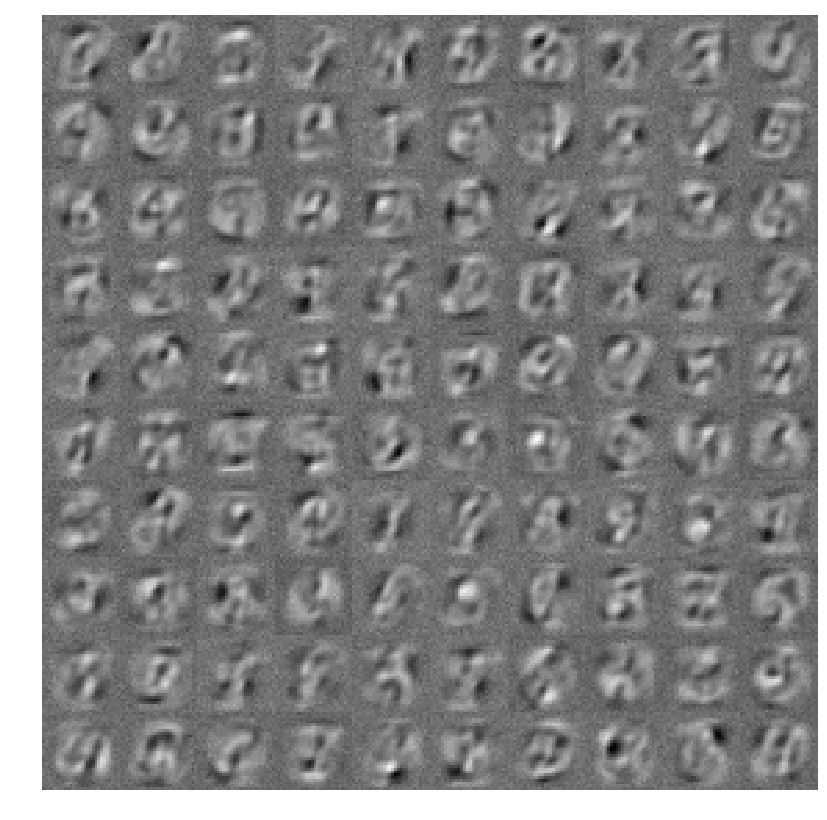

In [165]:
def mnist_test(n_epochs = 80, n_imgs = 5000, lr = 0.005):
    rbm = RBM(n_visible = 28 * 28, n_hidden = 100, n_epochs = n_epochs, batch_size = 100, learning_rate=lr)
    rbm.fit(mntrainx[0:n_imgs])
    return rbm
    
mnist_rbm= mnist_test()

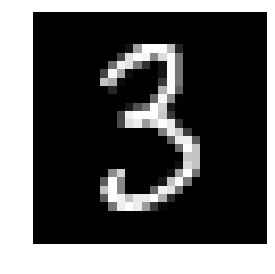

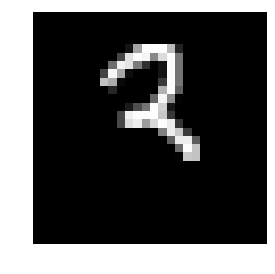

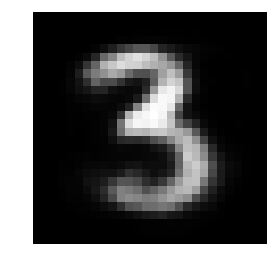

In [213]:
img = np.copy(mntrainx[np.random.randint(0, 5000)])
show(img.reshape(28, 28))
# for i in xrange(len(img)):
#     if np.random.randint(0, 10) == 1:
#         img[i] = 1.0
# n_img = random_noise(img, mode = "gaussian", var = 0.05)
n_img = np.append(img[0:500], [0.0 for i in xrange(284)], axis = 0)
# n_img = random_noise(img, mode = "s&p")
show(n_img.reshape(28, 28))
# show(mnist_rbm_200_40_001_20_50k.predict(n_img).reshape(28, 28))
show(mnist_rbm.reconstruct(n_img).reshape(28, 28))


In [ ]:
train_size = 1000
log = LogisticRegression(C=1.0)
# log.fit(mntrainx[0:train_size], mntrainy[0:train_size])
log.fit(mndata.train_images[:10000], mndata.train_labels[:10000])

In [ ]:
params = {"C": [1.0, 10.0, 100.0]} 
train_size = 10000
gs = GridSearchCV(LogisticRegression(), params, n_jobs = -1, verbose = 2)
gs.fit(mntrainx[0:train_size], mntrainy[0:train_size])
bestParams = gs.best_estimator_.get_params()
print bestParams


Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=1.0 ...........................................................
[CV] C=10.0 ..........................................................
[CV] C=10.0 ..........................................................
[CV] C=10.0 ..........................................................
[CV] C=100.0 .........................................................
[CV] C=100.0 .........................................................
[CV] C=100.0 .........................................................


Process PoolWorker-14:
Traceback (most recent call last):
  File "/home/denilv/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Process PoolWorker-12:
Process PoolWorker-17:
Process PoolWorker-15:
Process PoolWorker-13:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/denilv/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/denilv/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/denilv/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
  File "/home/denilv/anaconda2/lib/python2.7/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
    self.run()
    self.run()
    self.run()
    self.run()
  File "/home/denilv/anaconda2/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/home/denilv/anaconda2/lib/python2.7/multiproc

In [ ]:
params = {
        "rbm__learning_rate": [0.1, 0.01, 0.001],
        "rbm__n_iter": [20, 40, 80],
        "rbm__n_components": [50, 100, 200],
        "log__C": [1.0, 10.0, 100.0]}
Pipeline("rbm" : rbm, "log" : log)

In [13]:
def test_rbm():
    data = np.array([[1,1,1,0,0,0],
                        [1,0,1,0,0,0],
                        [1,1,1,0,0,0],
                        [0,0,1,1,1,0],
                        [0,0,1,1,0,0],
                        [0,0,1,1,1,0]])


    rng = np.random.RandomState(123)

    # construct RBM
#     rbm = RBM(input=data, n_visible=6, n_hidden=2, rng=rng)
    rbm = RBM(n_visible=6, n_hidden=10, learning_rate=0.2, n_epochs=1000, batch_size = 2)
    rbm.fit(data)

    # test
    v = np.array([[1, 1, 0, 0, 0, 0],
                    [0, 0, 0, 1, 1, 0]])

    print rbm.reconstruct(v)
    
test_rbm()

1000 epoch of 1000
[[ 0.99934388  0.87033472  0.99999085  0.00123878  0.00159628  0.00088431]
 [ 0.00049435  0.00198691  0.99977641  0.99971379  0.78767634  0.00138773]]


In [ ]:
zeros = []
for i, j in zip(mndata.train_images, mndata.train_labels):
    if j==0:
        zeros.append(i)
    if len(zeros) > 100:
        break

In [ ]:
import sys
import numpy

class RBM(object):
    def __init__(self, input=None, n_visible=2, n_hidden=3, \
        W=None, hbias=None, vbias=None, rng=None):
        
        self.n_visible = n_visible  # num of units in visible (input) layer
        self.n_hidden = n_hidden    # num of units in hidden layer

        if rng is None:
            rng = numpy.random.RandomState(1234)


        if W is None:
            a = 1. / n_visible
            initial_W = numpy.array(rng.uniform(  # initialize W uniformly
                low=-a,
                high=a,
                size=(n_visible, n_hidden)))

            W = initial_W

        if hbias is None:
            hbias = numpy.zeros(n_hidden)  # initialize h bias 0

        if vbias is None:
            vbias = numpy.zeros(n_visible)  # initialize v bias 0


        self.rng = rng
        self.input = input
        self.W = W
        self.hbias = hbias
        self.vbias = vbias


    def contrastive_divergence(self, lr=0.1, k=1, input=None):
        if input is not None:
            self.input = input
        
        ''' CD-k '''
        ph_mean, ph_sample = self.sample_h_given_v(self.input)

        chain_start = ph_sample

        for step in xrange(k):
            if step == 0:
                nv_means, nv_samples,\
                nh_means, nh_samples = self.gibbs_hvh(chain_start)
            else:
                nv_means, nv_samples,\
                nh_means, nh_samples = self.gibbs_hvh(nh_samples)
        show10x10(nv_means)
        # chain_end = nv_samples


        self.W += lr * (numpy.dot(self.input.T, ph_mean)
                        - numpy.dot(nv_samples.T, nh_means))
        self.vbias += lr * numpy.mean(self.input - nv_samples, axis=0)
        self.hbias += lr * numpy.mean(ph_mean - nh_means, axis=0)

        # cost = self.get_reconstruction_cross_entropy()
        # return cost


    def sample_h_given_v(self, v0_sample):
        h1_mean = self.propup(v0_sample)
        h1_sample = self.rng.binomial(size=h1_mean.shape,   # discrete: binomial
                                       n=1,
                                       p=h1_mean)

        return [h1_mean, h1_sample]


    def sample_v_given_h(self, h0_sample):
        v1_mean = self.propdown(h0_sample)
        v1_sample = self.rng.binomial(size=v1_mean.shape,   # discrete: binomial
                                            n=1,
                                            p=v1_mean)
        
        return [v1_mean, v1_sample]

    def propup(self, v):
        pre_sigmoid_activation = numpy.dot(v, self.W) + self.hbias
        return sigmoid(pre_sigmoid_activation)

    def propdown(self, h):
        pre_sigmoid_activation = numpy.dot(h, self.W.T) + self.vbias
        return sigmoid(pre_sigmoid_activation)


    def gibbs_hvh(self, h0_sample):
        v1_mean, v1_sample = self.sample_v_given_h(h0_sample)
        h1_mean, h1_sample = self.sample_h_given_v(v1_sample)

        return [v1_mean, v1_sample,
                h1_mean, h1_sample]
    

    def get_reconstruction_cross_entropy(self):
        pre_sigmoid_activation_h = numpy.dot(self.input, self.W) + self.hbias
        sigmoid_activation_h = sigmoid(pre_sigmoid_activation_h)
        
        pre_sigmoid_activation_v = numpy.dot(sigmoid_activation_h, self.W.T) + self.vbias
        sigmoid_activation_v = sigmoid(pre_sigmoid_activation_v)

        cross_entropy =  - numpy.mean(
            numpy.sum(self.input * numpy.log(sigmoid_activation_v) +
            (1 - self.input) * numpy.log(1 - sigmoid_activation_v),
                      axis=1))
        
        return cross_entropy

    def reconstruct(self, v):
        h = sigmoid(numpy.dot(v, self.W) + self.hbias)
        reconstructed_v = sigmoid(numpy.dot(h, self.W.T) + self.vbias)
        return reconstructed_v





def test_rbm(learning_rate=0.1, k=1, training_epochs=1000):
    data = numpy.array([[1,1,1,0,0,0],
                        [1,0,1,0,0,0],
                        [1,1,1,0,0,0],
                        [0,0,1,1,1,0],
                        [0,0,1,1,0,0],
                        [0,0,1,1,1,0]])


    rng = numpy.random.RandomState(123)

    # construct RBM
    rbm = RBM(input=data, n_visible=6, n_hidden=2, rng=rng)

    # train
    for epoch in xrange(training_epochs):
        rbm.contrastive_divergence(lr=learning_rate, k=k)
        # cost = rbm.get_reconstruction_cross_entropy()
        # print >> sys.stderr, 'Training epoch %d, cost is ' % epoch, cost


    # test
    v = numpy.array([[1, 1, 0, 0, 0, 0],
                     [0, 0, 0, 1, 1, 0]])

    print rbm.reconstruct(v)

def mnist_rbm(learning_rate=0.01, k=1, training_epochs=100):
    rng = numpy.random.RandomState(123)
    zeros = []
    for i, j in zip(mndata.train_images, mndata.train_labels):
        if j==0:
            zeros.append(i)
        if len(zeros) > 100:
            break
#     rbm.train(mndata.train_images[0:n_imgs], learning_rate = lr)
    rbm = RBM(input=np.array(zeros[0:100]), n_visible = 28 * 28, n_hidden = 100)
    for epoch in xrange(training_epochs):
        rbm.contrastive_divergence(lr=learning_rate, k=k)
    
    return rbm


if __name__ == "__main__":
    mnist_rbm()

In [ ]:
def fit1(self, X, learning_rate = 0.1, k = 1):
        X = np.array(X)
        for it in xrange(self.n_iters):
            sys.stdout.write('\r%s iteration of %s' % (it, self.n_iters))
            sys.stdout.flush()
            hstart_mean, hstart_sample = self.sample_hidden(X)
            h_mean, h_sample = hstart_mean, hstart_sample
            for i in xrange(k):
                v_mean, v_sample = self.sample_visible(h_sample)
                h_mean, h_sample = self.sample_hidden(v_sample)
            #X to numpy
#             show(v_mean[0])
#             show10x10(v_mean)
            showweights(self.weights)
            self.weights += learning_rate * (np.dot(X.T, hstart_mean) - np.dot(v_sample.T, h_mean))
            self.v_bias += learning_rate * np.mean(X - v_sample, axis = 0)
            self.h_bias += learning_rate * np.mean(hstart_mean - h_sample, axis = 0)
        sys.stdout.write('\r%s iteration of %s\n' % (self.n_iters, self.n_iters))
        
    def predict1(self, X):
        result = list()
        for x in X:
            h = self.up(x)
            v = self.down(h)
            result.append(v)
        return result
    
     def E(self, vis, hid):
        result = - vis.T * self.v_bias - hid.T * self.h_bias - vis * self.weights * hid
        return result
    
    def up(self, vis):
        sums = np.dot(vis, self.weights) + self.h_bias
        return sigmoid(sums)
    
    def down(self, hid):
        sums = np.dot(hid, self.weights.T) + self.v_bias
        return sigmoid(sums)
    
    def sample_hidden(self, visible):
        h1_mean = self.up(visible)
        h1_sample = np.random.binomial(n = 1, p = h1_mean, size = h1_mean.shape,)
        return (h1_mean, h1_sample)
    
    def sample_visible(self, hidden):
        v1_mean = self.down(hidden)
        v1_sample = np.random.binomial(n = 1, p = v1_mean, size = v1_mean.shape)
        return (v1_mean, v1_sample)